## Установка необходимых для работы библиотек
Необходимо выбрать `GPU` runtime type в настройках `runtime` google colab.
Обратите внимание, что установка может занять несколько минут (обычно 5 минут).

In [2]:
!pip install mesh_to_sdf pyrender trimesh
!pip install torch torchvision
!pip install 'git+https://github.com/facebookresearch/pytorch3d.git@stable'

     |████████████████████████████████| 1.2MB 26.3MB/s 
     |████████████████████████████████| 614kB 50.3MB/s 
     |████████████████████████████████| 890kB 51.7MB/s 
     |████████████████████████████████| 1.2MB 53.9MB/s 
  Created wheel for PyOpenGL: filename=PyOpenGL-3.1.0-cp36-none-any.whl size=1745212 sha256=06c6e5fa3758ec26acdb2af383656687102c5d9a4c55362ccfdeb85353307ba2
  Stored in directory: /root/.cache/pip/wheels/6c/00/7f/1dd736f380848720ad79a1a1de5272e0d3f79c15a42968fb58
Successfully built PyOpenGL
  Found existing installation: PyOpenGL 3.1.5
    Uninstalling PyOpenGL-3.1.5:
      Successfully uninstalled PyOpenGL-3.1.5
  Cloning https://github.com/facebookresearch/pytorch3d.git (to revision stable) to /tmp/pip-req-build-a5gl8g7_
  Running command git clone -q https://github.com/facebookresearch/pytorch3d.git /tmp/pip-req-build-a5gl8g7_
  Running command git checkout -q 686c8666d31d932ed42d3cd7319f249fc75e89a9
     |████████████████████████████████| 276kB 50.3MB/s 
  Creat

## Загрузка библиотек

In [0]:
import os
os.environ['PYOPENGL_PLATFORM'] = 'egl'

import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

import torch

# untilitis 
from pytorch3d.utils import ico_sphere

# loss functions and regulaziers
from pytorch3d.loss import (
    chamfer_distance,
    mesh_edge_loss,
    mesh_laplacian_smoothing,
    mesh_normal_consistency
)

# io utils
from pytorch3d.io import load_obj

# operations with data
from pytorch3d.ops import sample_points_from_meshes

# datastructures
from pytorch3d.structures import Meshes, Textures

# render 
from pytorch3d.renderer import (
    look_at_view_transform,
    OpenGLPerspectiveCameras,
    DirectionalLights, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    HardPhongShader
)

# mesh_to_sdf lib by marian42
from mesh_to_sdf import mesh_to_sdf, sample_sdf_near_surface

# trimesh lib imports
import trimesh
from trimesh.voxel.creation import voxelize

In [0]:
# If you have not got CUDA device, you can use CPU mode
# device = torch.device('cpu')

In [0]:
# If you have got a CUDA device, you can use GPU mode
device = torch.device('cuda:0')
torch.cuda.set_device(device)

# Полигональная модель

Загрузка полигональной модели `bunny.obj` с сайта [Stanford graphics](https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj), в случае, если работаем в colab.

In [5]:
!mkdir data
!wget -P /data/ https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj
path_to_model = r"/data/bunny.obj"

mkdir: cannot create directory ‘data’: File exists
--2020-05-19 16:06:05--  https://graphics.stanford.edu/~mdfisher/Data/Meshes/bunny.obj
Resolving graphics.stanford.edu (graphics.stanford.edu)... 171.67.77.70
Connecting to graphics.stanford.edu (graphics.stanford.edu)|171.67.77.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 205917 (201K) [text/plain]
Saving to: ‘/data/bunny.obj.1’

bunny.obj.1         100%[===================>] 201.09K   453KB/s    in 0.4s    

2020-05-19 16:06:06 (453 KB/s) - ‘/data/bunny.obj.1’ saved [205917/205917]



В случае, если работаем с кодом локально, просто создадим переменную пути до файла:

In [0]:
path_to_model = os.path.join("/data","bunny.obj")

### Создание полигональной икосферы sphere.obj с 4 уровнями subdivision

In [7]:
# Trimesh sphere .obj model
trimesh_sphere = trimesh.primitives.Sphere(subdivisions= 4)

# Sphere mesh in pytorch3d
sphere_mesh = ico_sphere(4, device)

verts_rgb = torch.ones_like(sphere_mesh.verts_list()[0])[None]

# Rainbow sphere in pytorch3d
# verts_rgb = torch.rand_like(sphere_mesh.verts_list()[0])[None]

sphere_mesh.textures = Textures(verts_rgb=verts_rgb.to(device))

/pytorch/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


### Создание полигональной модели кролика bunny.obj

In [9]:
# Trimesh bunny .obj model
bunny_trimesh = trimesh.load(path_to_model)

if isinstance(bunny_trimesh, trimesh.Scene):
    bunny_trimesh = bunny_trimesh.dump(concatenate=True)

bunny_trimesh.vertices -= bunny_trimesh.center_mass
scaling= 2 / bunny_trimesh.scale
bunny_trimesh.apply_scale(scaling=scaling)

# Rainbow bunny in trimesh
# for facet in bunny_trimesh.facets:
#   bunny_trimesh.visual.face_colors[facet] = trimesh.visual.random_color() 

# Bunny mesh in pytorch3d
verts, faces_idx, _ = load_obj(r"/data/bunny.obj")
faces = faces_idx.verts_idx

center = verts.mean(0)
verts = verts - center
scale = max(verts.abs().max(0)[0])
verts = verts / scale

# Initialize each vertex to be white in color.
verts_rgb = torch.ones_like(verts)[None]  # (1, V, 3)

# Rainbow bunny in pytorch3d
# verts_rgb = torch.rand_like(verts)[None]

textures = Textures(verts_rgb=verts_rgb.to(device))

# Create a Meshes object for the bunny.
bunny_mesh = Meshes(
    verts=[verts.to(device)],   
    faces=[faces.to(device)], 
    textures=textures
)

/usr/local/lib/python3.6/dist-packages/pytorch3d/io/obj_io.py:70: UserWarning: Faces have invalid indices
  warnings.warn("Faces have invalid indices")


### Преобразование полигональной модели к облаку точек с нормалями

Один из основных способов создания модели облака точек из существующей полигональной модели - равномерное семплирование дополнительных вершин на гранях полигональной модели. 

Эту задачу можно решать как встроеными методами библиотек - `sample_points_from_meshes` в *pytorch3d*, или же можно сакмому написать алгоритм семплирования и использовать его.

In [0]:
# Mesh to pointcloud with normals in pytorch3d
num_points_to_sample = 25000

bunny_vert, bunny_norm = sample_points_from_meshes(
    bunny_mesh,
    num_points_to_sample ,
    return_normals=True
)

sphere_vert, sphere_norm = sample_points_from_meshes(
    sphere_mesh,
    num_points_to_sample,
    return_normals=True
)

In [0]:
# Farthest point sampling realization

# compute triangle mesh surface area
def triangle_area(x):
    a = x[:,0,:] - x[:,1,:]
    b = x[:,0,:] - x[:,2,:]
    cross = np.cross(a, b)
    area = 0.5 * np.linalg.norm(np.cross(a, b), axis=1)
    return area

# compute euclidean distance matrix
def euclidean_distance_matrix(x):
    r = np.sum(x*x, 1)
    r = r.reshape(-1, 1)
    distance_mat = r - 2*np.dot(x, x.T) + r.T
    #return np.sqrt(distance_mat)
    return distance_mat

# update distance matrix and select the farthest point from set S after a new point is selected
def update_farthest_distance(far_mat, dist_mat, s):
    for i in range(far_mat.shape[0]):
        far_mat[i] = dist_mat[i,s] if far_mat[i] > dist_mat[i,s] else far_mat[i]
    return far_mat, np.argmax(far_mat)

# initialize matrix to keep track of distance from set s
def init_farthest_distance(far_mat, dist_mat, s):
    for i in range(far_mat.shape[0]):
        far_mat[i] = dist_mat[i,s]
    return far_mat
   
# get sample from farthest point on every iteration
def farthest_point_sampling(mesh, num_samples=1000):
    faces = mesh.vertices[mesh.faces]
    area = triangle_area(faces)
    total_area = np.sum(area)
    
    set_P = []
    for i in range(faces.shape[0]):
        num_gen = area[i] / total_area * 10000
        for j in range(int(num_gen)+1):
            r1, r2 = np.random.rand(2)
            d = (1-np.sqrt(r1)) * faces[i,0] + np.sqrt(r1)*(1-r2) * faces[i,1] + np.sqrt(r1)*r2 * faces[i,2]
            set_P.append(d)

    set_P = np.array(set_P)
    num_P = set_P.shape[0]
    
    distance_mat = euclidean_distance_matrix(set_P)
    
    set_S = []
    s = np.random.randint(num_P)
    far_mat = init_farthest_distance(np.zeros((num_P)), distance_mat, s)

    for i in range(num_samples):
        set_S.append(set_P[s])
        far_mat, s = update_farthest_distance(far_mat, distance_mat, s)
    
    return np.array(set_S)

# Блок визуализации

Визуализация облака точек, полученного из полигональной модели методом семплирования точек на гранях обоими методами.

In [0]:
def plot_pointcloud(mesh,num_points=5000 ,method="pytorch3d", elev=70, azim=-70, title=""):
    # Sample points uniformly from the surface of the mesh.
    fig = plt.figure(figsize=(10, 10))
    ax = Axes3D(fig)

    if method == "pytorch3d":
      points = sample_points_from_meshes(mesh, num_points)
      x, y, z = points.clone().detach().cpu().squeeze().unbind(1)
      # ax = Axes3D(fig)
      ax.scatter3D(x, z, -y,marker='.')
  
    if method == "own":
      points = farthest_point_sampling(mesh, num_points)
      # ax = fig.add_subplot(111, projection="3d")
      x, y, z = points[:, 0], points[:, 1], -points[:, 2]
      # ax.scatter(points[:, 0], points[:, 1], zs=-points[:, 2])
      ax.scatter3D(x, z, -y,marker='.')  
    
    ax.set_xlabel('x')
    ax.set_ylabel('z')
    ax.set_zlabel('y')
    ax.set_title(title)
    ax.view_init(elev, azim)
    plt.show()

Визуализация моделей с помощью дифференциального рендера pytorch3d

In [0]:
# Initialize an OpenGL perspective camera.
cameras = OpenGLPerspectiveCameras(device=device)

# We will also create a phong renderer. This is simpler and only needs to render one face per pixel.
raster_settings = RasterizationSettings(
    image_size=1024, 
    blur_radius=0, 
    faces_per_pixel=1, 
)

# We can add a point light in front of the object. 
#lights = PointLights(device=device, location=((2.0, 2.0, -2.0),))
ambient_color = torch.FloatTensor([[0.0, 0.0, 0.0]]).to(device)
diffuse_color = torch.FloatTensor([[1.0, 1.0, 1.0]]).to(device)
specular_color = torch.FloatTensor([[0.1, 0.1, 0.1]]).to(device)
direction = torch.FloatTensor([[1, 1, 1]]).to(device)
lights = DirectionalLights(ambient_color=ambient_color,
                           diffuse_color=diffuse_color,
                           specular_color=specular_color,
                           direction=direction,
                           device=device)

phong_renderer = MeshRenderer(
    rasterizer=MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    ),
    shader=HardPhongShader(device=device, cameras=cameras, lights=lights)
)

In [0]:
# Select the viewpoint using spherical angles  
distance = 2.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

# Render the bunny providing the values of R and T. 
image_bunny = phong_renderer(meshes_world=bunny_mesh, R=R, T=T)

In [0]:
# Select the viewpoint using spherical angles  
distance = 3.0   # distance from camera to the object`
elevation = 40.0   # angle of elevation in degrees
azimuth = 0.0  # No rotation so the camera is positioned on the +Z axis. 

# Get the position of the camera based on the spherical angles
R, T = look_at_view_transform(distance, elevation, azimuth, device=device,at=((-0.02,0.1,0.0),))

# Render the sphere providing the values of R and T. 
image_sphere = phong_renderer(meshes_world=sphere_mesh, R=R, T=T)

# Полигональные модели

### Визуализация в pytorch3d

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


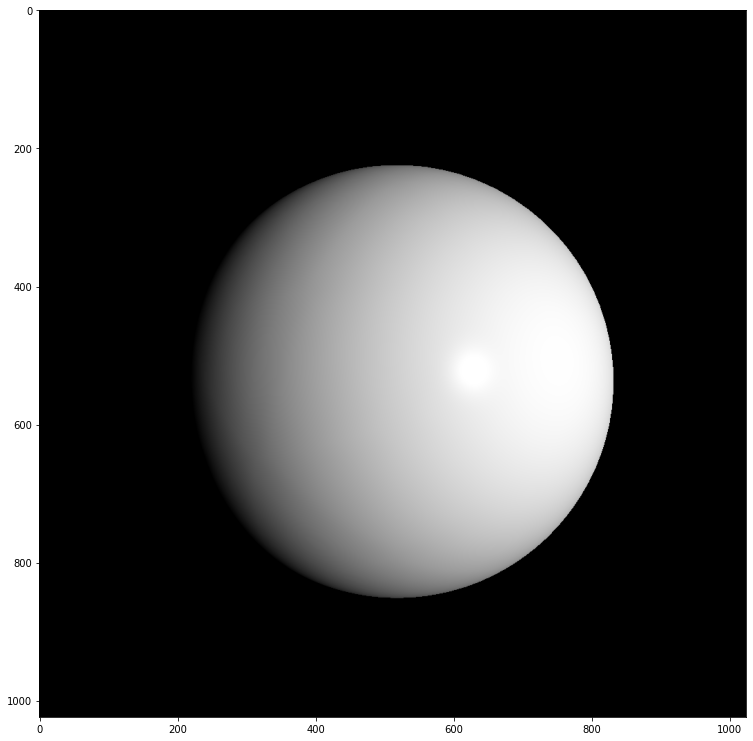

In [16]:
image_sphere = image_sphere.cpu().numpy()

plt.figure(figsize=(13, 13))
plt.imshow(image_sphere.squeeze())
plt.grid(False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


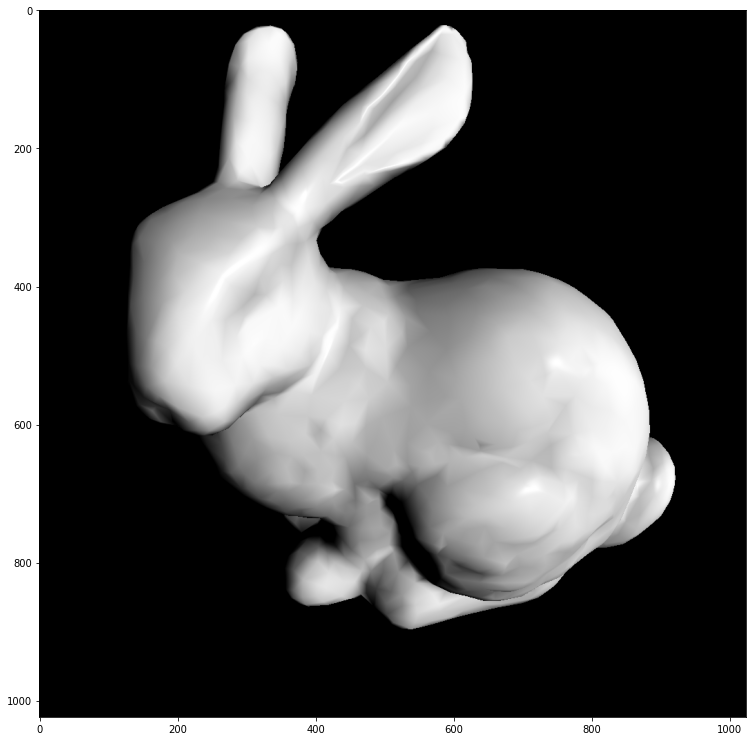

In [17]:
image_bunny = image_bunny.cpu().numpy()

plt.figure(figsize=(13, 13))
plt.imshow(image_bunny.squeeze())
plt.grid(False)

### Интерактивная визуализация в trimesh

In [0]:
trimesh_sphere.show()

In [18]:
bunny_trimesh.show()

 ### Для полигональных моделей как для пространственных графов можно вычислить ряд геометрических характеристик.

In [0]:
print(
    "Эйлерова характеристика пространственного графа модели bunny Xi = V - E + F =",
    bunny_trimesh.euler_number
)

print(
    "Эйлерова характеристика пространственного графа модели sphere Xi = V - E + F =",
    trimesh_sphere.euler_number
)

Эйлерова характеристика пространственного графа модели bunny Xi = V - E + F = -2
Эйлерова характеристика пространственного графа модели sphere Xi = V - E + F = 2


In [0]:
print("Is bunny mesh watertight:", bunny_trimesh.is_watertight)
print("Is sphere mesh watertight:", trimesh_sphere.is_watertight)

Is bunny mesh watertight: False
Is sphere mesh watertight: True


In [0]:
print("Объем модели bunny.obj:", bunny_trimesh.volume)
print("Объем модели sphere.obj:", trimesh_sphere.volume)

Объем модели bunny.obj: 0.3876657353353089
Объем модели sphere.obj: 4.1887902047863905


In [0]:
# Объем единичной сферы 4/3 * Pi
(4/3)*np.pi

4.1887902047863905

# Воксельное представление

In [0]:
low_idx_bunny = bunny_trimesh.scale / 15
high_idx_bunny = bunny_trimesh.scale / 39
low_idx_sphere = trimesh_sphere.scale / 15
high_idx_sphere = trimesh_sphere.scale / 39

In [0]:
vox_high_bunny = voxelize(bunny_trimesh,pitch=high_idx_bunny)
vox_high_sphere = voxelize(trimesh_sphere,pitch=high_idx_sphere)

In [0]:
print("Размер воксельной сетки с высоким разрешением:", vox_high_sphere.shape)

Размер воксельной сетки с высоким разрешением: (23, 23, 23)


In [0]:
vox_high_sphere.show()

In [0]:
vox_high_bunny.show()

In [0]:
vox_low_bunny = voxelize(bunny_trimesh,pitch=low_idx_bunny)
vox_low_sphere = voxelize(trimesh_sphere,pitch=low_idx_sphere)

In [0]:
print("Размер воксельной сетки с низким разрешением:", vox_low_sphere.shape)

Размер воксельной сетки с низким разрешением: (9, 9, 9)


In [0]:
vox_low_sphere.show()

In [0]:
vox_low_bunny.show()

# Вычисление SDF функции

Вычисление SDF функции для модели bunny.obj в двух точках: одной внутренней (центр масс), одной внешней.

In [0]:
center_mass = bunny_trimesh.center_mass
query_points = np.array([[center_mass],[[3,3,3]]])

In [0]:
for point in query_points:
    print("SDF{0} = {1}".format(point[0],mesh_to_sdf(bunny_trimesh,point)[0]))

SDF[-0.00036814  0.01044934 -0.00012521] = -0.26781705021858215
SDF[3. 3. 3.] = 4.746691703796387


Вычисление SDF функции для модели sphere.obj в двух точках: одной внутренней (центр масс), одной внешней.

In [0]:
center_mass = trimesh_sphere.center_mass
query_points = np.array([[center_mass],[[3,3,3]]])

In [0]:
for point in query_points:
    print("SDF{0} = {1}".format(point[0],mesh_to_sdf(trimesh_sphere,point)[0]))

SDF[ 0.0000000e+00  0.0000000e+00 -8.8540061e-18] = -0.9988667964935303
SDF[3. 3. 3.] = 4.195330619812012


Визуализируем 

In [0]:
points, sdf = sample_sdf_near_surface(trimesh_sphere, number_of_points=5000)

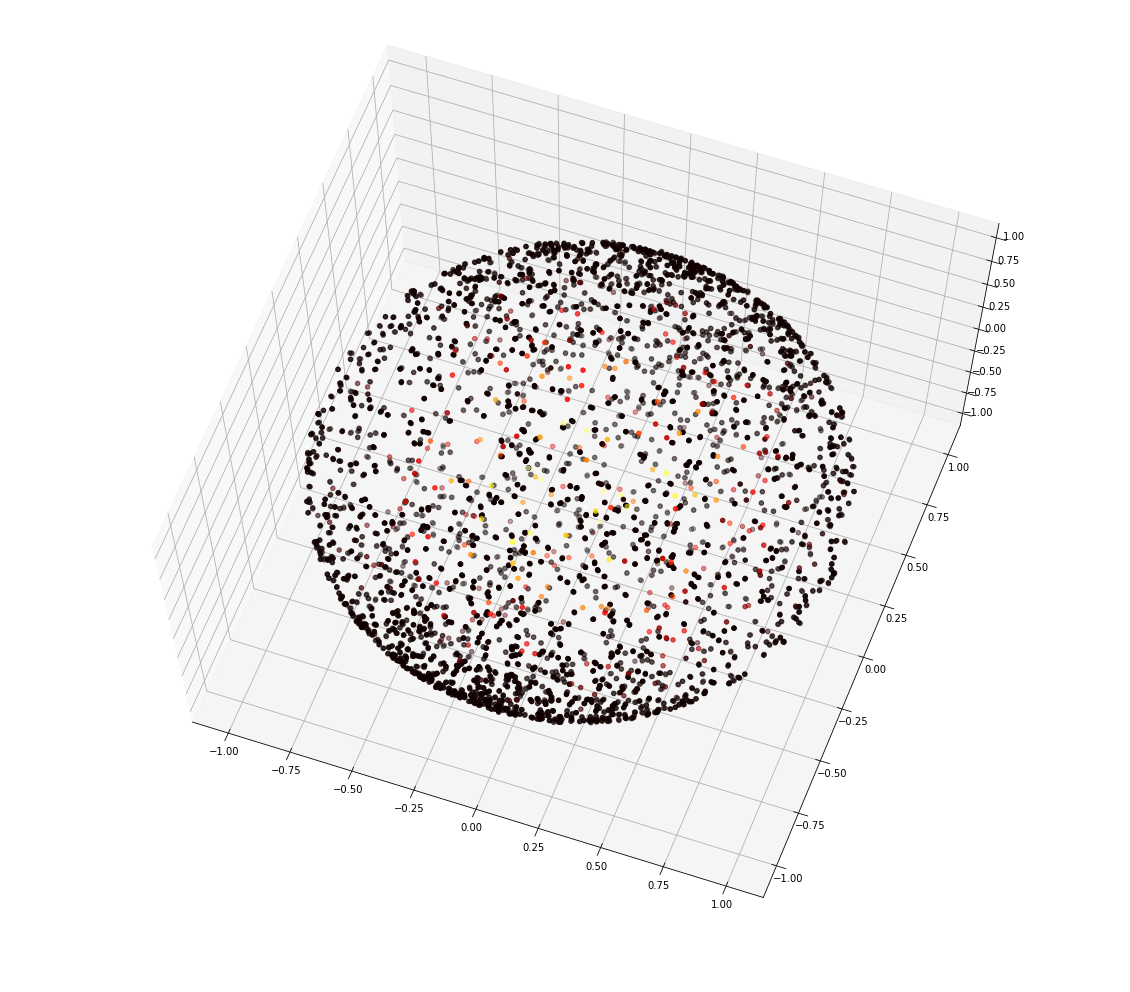

In [0]:
fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=70, azim=-70)
ax.scatter(points[:, 0], points[:, 1], zs=-points[:, 2], c=sdf, cmap="hot_r")

In [0]:
points, sdf = sample_sdf_near_surface(bunny_trimesh, number_of_points=5000)

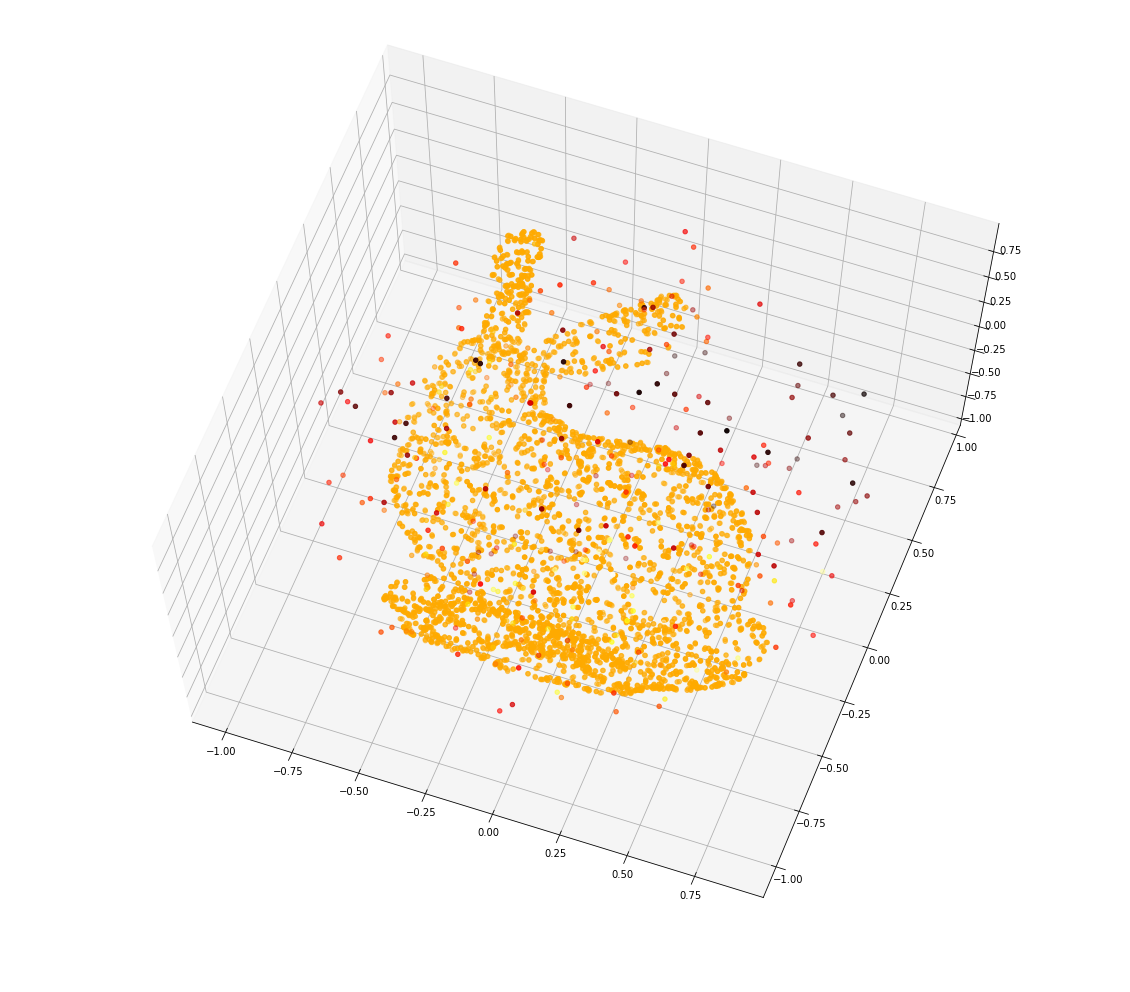

In [0]:
fig = plt.figure(figsize=(20, 18))
ax = fig.add_subplot(111, projection="3d")
ax.view_init(elev=70, azim=-70)
ax.scatter(points[:, 0], points[:, 1], zs=-points[:, 2], c=sdf, cmap="hot_r")

# Облако точек

Облако точек модели bunny.obj, полученное семплированием с помощью алгоритма из pytorch3d.

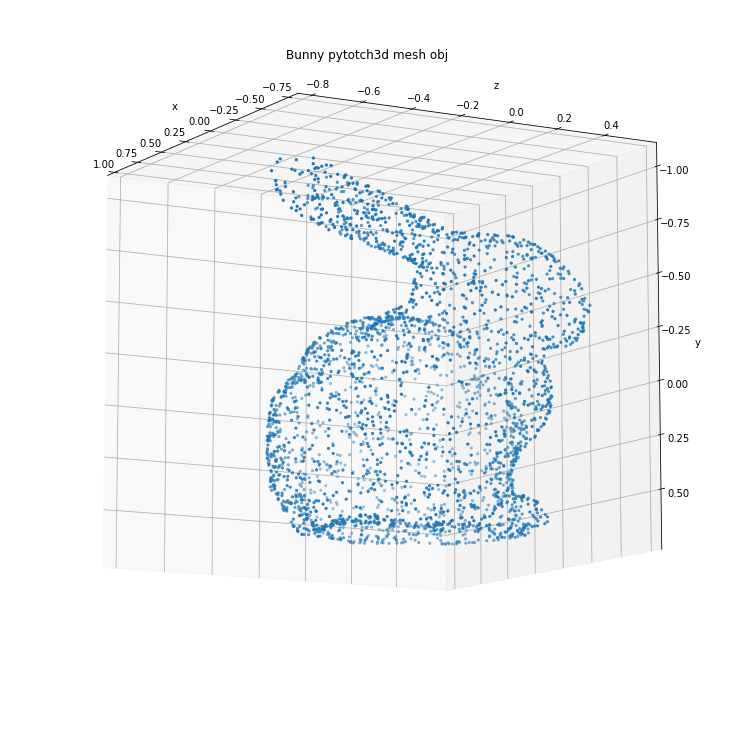

In [0]:
plot_pointcloud(bunny_mesh, num_points=3000,elev=170, azim=30, title='Bunny pytotch3d mesh obj')

Облако точек модели bunny.obj, полученное семплированием с помощью алгоритма Farthest point sampling.

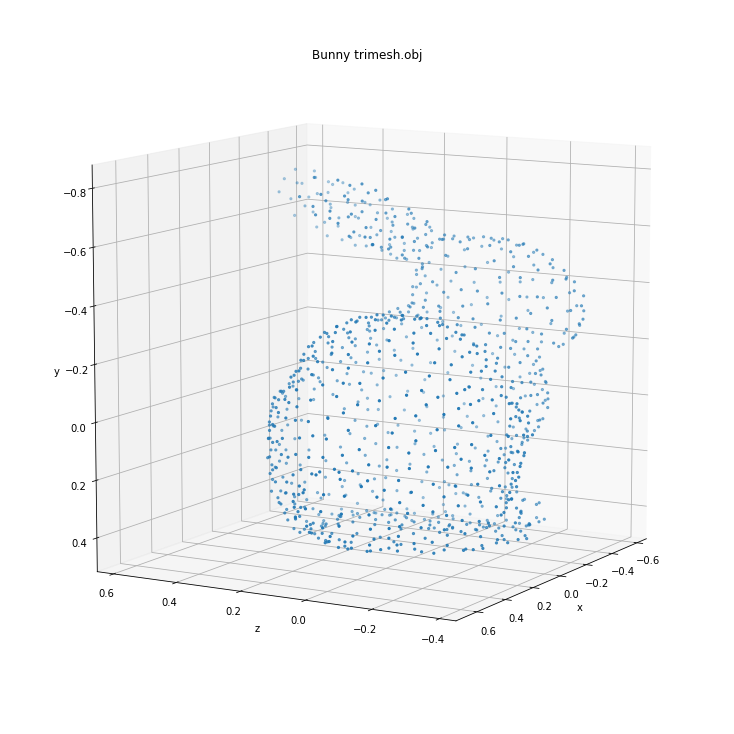

In [0]:
plot_pointcloud(bunny_trimesh,num_points=1000,method='own',elev=190, azim=150,title='Bunny trimesh.obj')

Облако точек модели sphere.obj, полученное семплированием с помощью алгоритма из pytorch3d.

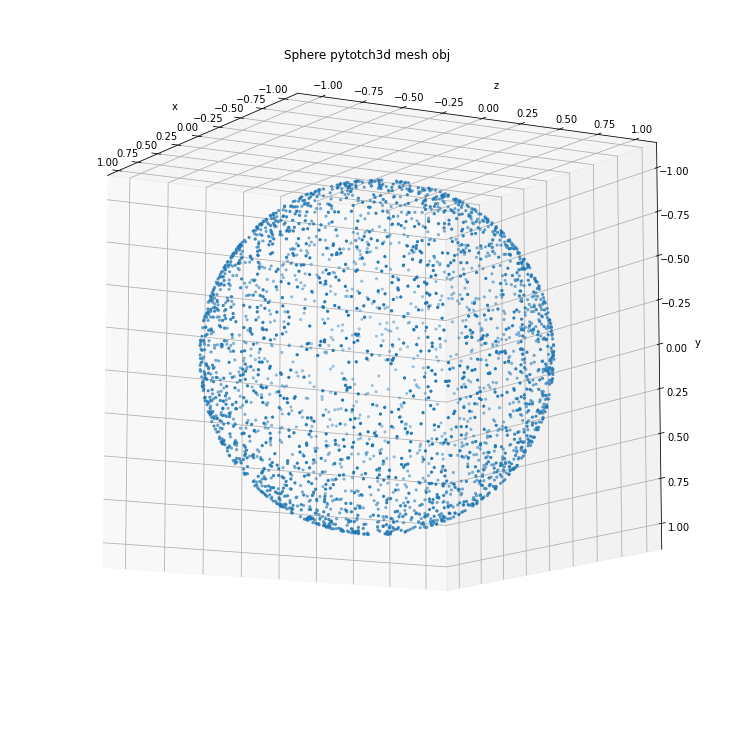

In [0]:
plot_pointcloud(sphere_mesh, num_points=3000,elev=170, azim=30, title='Sphere pytotch3d mesh obj')

Облако точек модели sphere.obj, полученное семплированием с помощью алгоритма Farthest point sampling.

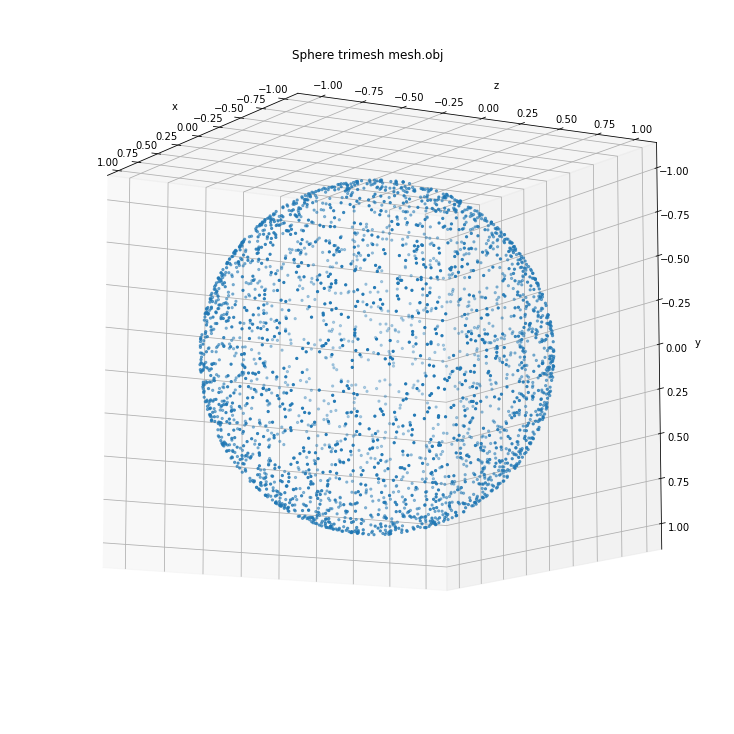

In [0]:
plot_pointcloud(sphere_mesh, num_points=3000,elev=170, azim=30, title='Sphere trimesh mesh.obj')

# Вычисление метрик и регуляризаторов

### Вычисление метрик *chamfer loss* и *normal loss*. 

In [0]:
# Chamfer loss and normal loss
loss_chamfer, loss_normals_chamfer = chamfer_distance(
    bunny_vert, 
    sphere_vert, 
    x_normals=bunny_norm,
    y_normals=sphere_norm
)

In [20]:
print("Chamfer loss =", loss_chamfer.item())
print("Normal loss =", loss_normals_chamfer.item())

Chamfer loss = 0.2620205283164978
Normal loss = 0.4745953679084778


### Вычисление различных регуляризаторов.

In [21]:
print("Edge loss for bunny.obj:", mesh_edge_loss(bunny_mesh).item())
print("Edge loss for sphere.obj:", mesh_edge_loss(sphere_mesh).item())

Edge loss for bunny.obj: 0.004127349238842726
Edge loss for sphere.obj: 0.005724199116230011


In [22]:
print("Laplacian smoothing objective for bunny.obj:", mesh_laplacian_smoothing(bunny_mesh).item())
print("Laplacian smoothing objective for sphere.obj:", mesh_laplacian_smoothing(sphere_mesh).item())

Laplacian smoothing objective for bunny.obj: 0.014459558762609959
Laplacian smoothing objective for sphere.obj: 0.0040009506046772


In [23]:
print("Smooth regularizer for bunny.obj:", mesh_normal_consistency(bunny_mesh).item())
print("Smooth regularizer for sphere.obj:", mesh_normal_consistency(sphere_mesh).item())

Smooth regularizer for bunny.obj: 0.03854169696569443
Smooth regularizer for sphere.obj: 0.0009780693799257278
